In [ ]:
%pip install google-genai
%pip install matplotlib
%pip install os
%pip install dotenv
%pip install pydantic

In [ ]:
from google import genai
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from dotenv import load_dotenv
from google.genai import types
from pydantic import BaseModel, Field
from io import BytesIO
from PIL import Image
from IPython.display import Markdown

In [ ]:
def create_genai_client():
    import os

    api_key = os.getenv("GOOGLE_API_KEY")
    if not api_key:
        raise ValueError("GOOGLE_API_KEY not found in .env file")    

    # Configure the client with your API key
    client = genai.Client(api_key=api_key, http_options={'api_version': 'v1alpha'})

    return client

In [ ]:
def load_image(image_path: str):
    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: The file at '{image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
def get_inline_data_part(image_path: str):
    import mimetypes

    try:
        mime_type, _ = mimetypes.guess_type(image_path)
        if mime_type is None:
            mime_type = 'application/octet-stream'
            print(f"Warning: Could not determine MIME type for {image_path}. Defaulting to {mime_type}.")

        file_bytes: bytes | None = None
        with open(image_path, "rb") as image_file:
            file_bytes = image_file.read()
        
        if file_bytes is None:
            raise Exception(f"Unable to read the bytes from {image_path}")
    
        return types.Part(
            inline_data=types.Blob(
                mime_type=mime_type,
                data=file_bytes
            ),
            media_resolution={"level": "media_resolution_high"}
        ) 
    except FileNotFoundError:
        print (f"Error: The file was not found at {image_path}")
    except Exception as e:
        print (f"An error occurred: {e}")

In [ ]:
def print_token_usage(response: types.GenerateContentResponse):
    if response and response.usage_metadata:
        usage_metadata = response.usage_metadata
        input_token_count = usage_metadata.prompt_token_count
        output_token_count = usage_metadata.candidates_token_count
        total_token_count = usage_metadata.total_token_count
        thought_token_count = usage_metadata.thoughts_token_count
        cached_token_count = usage_metadata.cached_content_token_count
        print(f"Input: {input_token_count}, Output: {output_token_count}, Thought: {thought_token_count}, Cached: {cached_token_count} Total: {total_token_count}")

In [ ]:
load_dotenv()

# Configure the client with your API key
client = create_genai_client()

tools = [types.Tool(google_search=types.GoogleSearch())]

In [ ]:
def get_num_citations(grounding_supports: list[types.GroundingSupport] | None):
    num_citations = 0
    for support in grounding_supports or []:
        if support.grounding_chunk_indices:
            num_citations = num_citations + len(support.grounding_chunk_indices)

    return num_citations

In [ ]:
def build_citations(grounding_supports: list[types.GroundingSupport] | None, grounding_chunks: list[types.GroundingChunk] | None):
    citations: list[str] = []
    for support in grounding_supports:
        if support.grounding_chunk_indices:
            for i in support.grounding_chunk_indices:
                uri = ''
                if grounding_chunks and i < len(grounding_chunks):
                    chunk = grounding_chunks[i]
                    uri = chunk.web.uri if chunk.web and chunk.web.uri else ''
                if uri:
                    citations.append(uri)

    text_citations = "\nCitation link: ".join(citations)
    return "Citation link: " + text_citations

In [ ]:
def taipei_weather_forecast():
    prompt = """
    Please search for the latest confirmed weather forecast for Taiwan for the dates listed below in 2025. specifically looking at Taipei and Taoyuan.

    Present the results in a single clear table with the following columns: Date, Location, Weather (Condition, Temp in °C, Precipitation %), and Appropriate Clothing.

    The dates and locations are:
    1. Taipei: November 26, 27, 28, and 29.
    2. Taoyuan: November 30 and December 1.
    """
    response = client.models.generate_content(
        model="gemini-3-pro-preview",
        contents=[types.Content(parts=[types.Part(text=prompt)])],
        config=types.GenerateContentConfig(
            tools=tools,
            thinking_config=types.ThinkingConfig(
                thinking_level=types.ThinkingLevel.HIGH
            ),
        )
    )

    print_token_usage(response)
    return response

In [162]:
def generate_weather_forecast():
    prompt = """
    Please search for the latest confirmed weather forecast for Taiwan for the dates listed below in 2025. specifically looking at Taipei and Taoyuan.
    The dates and locations are:
    1. Taipei: November 26, 27, 28, and 29.
    2. Taoyuan: November 30 and December 1.
    November has 30 days, so avoid doing weather forecast for November 31.
    Then generate a weather forecast image, add appropriate clothing on each day and in Traditional Chinese.
    """

    response = client.models.generate_content(
        model="gemini-3-pro-image-preview",
        contents=[types.Content(parts=[types.Part(text=prompt)])],
        config=types.GenerateContentConfig(
            response_modalities=['TEXT', 'IMAGE'],
            thinking_config=types.ThinkingConfig(
                include_thoughts=True,
                thinking_budget=512,
            ),
            tools=tools,
        )
    )

    image_bytes: bytes | None = None
    print_token_usage(response)
    if response.candidates and response.candidates[0].content and response.candidates[0].content.parts:
        for part in response.candidates[0].content.parts:
            if part.thought and part.text:
                display(Markdown(f"Though Summary:\n {part.text}"))
            elif part.text:
                print("Text: ", part.text)
            elif part.inline_data:
                image_bytes = part.inline_data.data
       
    return image_bytes

In [ ]:
def generate_trip_poster():
    prompt = """
    A vertical movie-style travel poster titled "TAIPEI 2025" in Traditional Chinese. 
    The composition is a dynamic vertical montage illustrating a journey.
    Please use Google Search tool to find out how the landmarks look like and include them in the poster.

    Visual Elements (blended from bottom to top):
    1. Bottom Section (City & Tech): A bustling street scene featuring "Tenlong Computer Books" and stacks of coding books, merging into the bright neon lights of Ximending and the towering Taipei 101 at night.
    2. Middle Section (Nature & Relax): Steam rising from a traditional Beitou Hot Spring bath set against the lush green backdrop of Yangmingshan mountains.  Please display Beitou and Yangmingshan in Traditional Chinese. 
    3. Top Section (Action & Return): A dynamic female pro-wrestling ring scene (Diana Wrestling) acting as the climax, Azure AI Logo over 臺灣大學社會科學院, with a stylized airplane flying overhead towards a silhouette of the Hong Kong skyline in the clouds.
    4. The female wreslers must look Japanese or Taiwanese.
    
    Style: Vibrant semi-realistic digital art, high saturation, distinct color zones for each location, 8k resolution, cinematic lighting, highly detailed.
    """

    response = client.models.generate_content(
        model="gemini-3-pro-image-preview",
        contents=[
            types.Content(
                parts=[types.Part(text=prompt)]
            )
        ],
        config=types.GenerateContentConfig(
            response_modalities=['TEXT', 'IMAGE'],
            thinking_config=types.ThinkingConfig(
                include_thoughts=True,
                thinking_budget=512,
            ),
            tools=tools,
            image_config=types.ImageConfig(
                aspect_ratio="9:16",
                image_size="4K"
            )
        )
    )

    image_bytes: bytes | None = None
    print_token_usage(response)
    if response.candidates and response.candidates[0].content and response.candidates[0].content.parts:
        for part in response.candidates[0].content.parts:
            if part.thought and part.text:
                display(Markdown(f"Though Summary:\n {part.text}"))
            elif part.text:
                print("Text: ", part.text)
            elif part.inline_data:
                image_bytes = part.inline_data.data
       
    return image_bytes

In [ ]:
response = taipei_weather_forecast()

# print the response
display(Markdown(f"Response:\n {response.text}"))

grounding_metadata = response.candidates[0].grounding_metadata if response.candidates and response.candidates[0] and response.candidates[0].grounding_metadata else None
grounding_chunks = grounding_metadata.grounding_chunks if grounding_metadata.grounding_chunks else None
grounding_supports = grounding_metadata.grounding_supports if grounding_metadata.grounding_supports else None
if grounding_supports:
    print (f"{get_num_citations(grounding_supports)} Citations")
    citations = build_citations(grounding_supports=grounding_supports, grounding_chunks=grounding_chunks)
    print(citations)

Input: 124, Output: 1926, Thought: 363, Cached: 72 Total: 2413


Though Summary:
 **Compiling Weather Data**

I'm gathering the latest weather forecasts for Taipei and Taoyuan for late November and early December 2025. I'm focusing on reliable meteorological sources to ensure accuracy. Next, I'll organize the temperature, weather conditions, and clothing recommendations for each date and location. Then, I will design a clear and informative visual layout for the forecast.




Though Summary:
 **Summarizing Weather Data**

I've finished gathering weather forecast data for Taipei and Taoyuan from various sources for the specified dates. The information is organized by location and date, with details on temperature ranges, precipitation likelihood, and the influence of the northeast monsoon. I can now proceed to develop a visual weather forecast, including clothing recommendations, categorizing the weather conditions, and formatting the information for the final image generation using Traditional Chinese.




Though Summary:
 **Analyzing Meteorological Data**

I've completed the weather forecast images for Taipei and Taoyuan. I've presented temperature ranges, weather descriptions, and suggested attire in Traditional Chinese. The image delivers all specified details in a straightforward manner. The layout's easy to grasp. Information has been double-checked to align with external data.




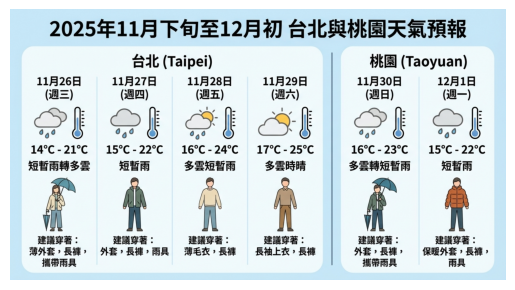

In [166]:
image_bytes = generate_weather_forecast()
image = Image.open(BytesIO(image_bytes)) if image_bytes else None
if image:
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    image.save('./weather_forecast.png')

Input: 262, Output: 2355, Thought: 616, Cached: 164 Total: 3233


Though Summary:
 **Designing the Poster Concept**

I'm currently focused on the poster's conceptual framework. I've begun gathering visual and descriptive data on the requested Taipei landmarks and cultural elements. The aim is a vertical montage, layered from bottom to top, each section with its own distinct color palette: warm city lights, cool nature tones, and energetic action hues. The overall goal is a high-saturation digital artwork with cinematic lighting.




Though Summary:
 **Designing a Dynamic Montage**

I'm currently focused on the poster's visual structure. The goal is to blend three distinct sections – city & tech, nature & relaxation, and action & return – into a cohesive vertical design. Each section will have specific elements representing "TAIPEI 2025," aiming for a vibrant, semi-realistic aesthetic. I'm paying close attention to the transitions between sections, ensuring a smooth flow from Tenlong Computer Books to the azure AI logo and eventually to the HK skyline. The interplay of warm and cool tones, as well as the overall saturation, is crucial for creating the desired cinematic effect.




Though Summary:
 **Validating Poster Details**

My focus is confirming the design matches the prompt's specifics. I assessed the poster's components: the requested locations like Tenlong Books and Beitou Hot Springs are present. The composition uses a vertical montage as requested. The Traditional Chinese text elements were included and properly placed. The current generation seems to meet the requirements of the prompt.




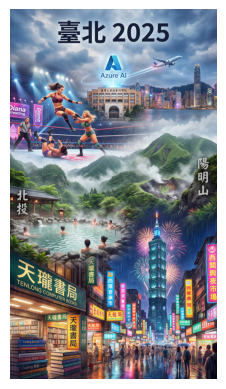

In [167]:
image_bytes = generate_trip_poster()
image = Image.open(BytesIO(image_bytes)) if image_bytes else None
if image:
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    image.save('./poster.png')